In [691]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LassoLars
from sklearn.cross_validation import train_test_split, cross_val_score
from statsmodels.discrete.discrete_model import Logit
from pandas.tools.plotting import scatter_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve
import pandas as pd
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from __future__ import division
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import scale, StandardScaler
import pygal
import matplotlib.cm as cm, matplotlib.font_manager as fm
from seaborn import violinplot, boxplot, kdeplot
%matplotlib inline

In [120]:
X_ver2 = pd.read_csv('X_group_bat.csv')

In [37]:
y = X_ver2.pop('Rookie?')

In [38]:
X_ver2 = X_ver2.drop(['player_id', 'Year'], axis=1)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_ver2, y)

In [50]:
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_sample(X_train, y_train)

In [51]:
#logit_mod = Logit(y_resampled, X_resampled).fit()
#logit_mod.summary()

In [52]:
sklogit = LogisticRegression()
RF = RandomForestClassifier(n_estimators=200, n_jobs=4)
GB = GradientBoostingClassifier(n_estimators=500)

In [53]:
sklogit.fit(X_resampled, y_resampled)
RF.fit(X_resampled, y_resampled)
GB.fit(X_resampled, y_resampled)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [54]:
print sklogit.score(X_test, y_test)
print RF.score(X_test, y_test)
print GB.score(X_test, y_test)

0.760416666667
0.80530394525
0.790911835749


In [55]:
y_pred_logit = sklogit.predict(X_test)
y_pred_RF = RF.predict(X_test)
y_pred_GB = GB.predict(X_test)
y_proba_logit = sklogit.predict_proba(X_test)
y_proba_RF = RF.predict_proba(X_test)
y_proba_GB = GB.predict_proba(X_test)

In [56]:
print precision_score(y_test, y_pred_logit)
print precision_score(y_test, y_pred_RF)
print precision_score(y_test, y_pred_GB)

0.0309172809173
0.0352644836272
0.0333333333333


In [57]:
print recall_score(y_test, y_pred_logit)
print recall_score(y_test, y_pred_RF)
print recall_score(y_test, y_pred_GB)

0.843575418994
0.782122905028
0.793296089385


In [58]:
print roc_auc_score(y_test, y_pred_logit)
print roc_auc_score(y_test, y_pred_RF)
print roc_auc_score(y_test, y_pred_GB)

0.801618106085
0.793818777452
0.792093126702


In [59]:
confusion_matrix(y_test, y_pred_logit)

array([[14960,  4733],
       [   28,   151]])

In [60]:
y_test.value_counts()

0.0    19693
1.0      179
Name: Rookie?, dtype: int64

In [61]:
y_test.shape

(19872,)

In [62]:
y_test_copy = y_test.copy()

In [63]:
y_test_copy.index = range(y_test_copy.shape[0])

In [64]:
true_idx_0 = y_test_copy[y_test_copy == 0].index

In [65]:
true_idx_1 = y_test_copy[y_test_copy==1].index

In [66]:
pred_idx_1 = np.where(y_pred_logit == 1)

In [67]:
pred_idx_0 = np.where(y_pred_logit == 0)

In [68]:
FP_idx = np.intersect1d(true_idx_0, pred_idx_1) # 실제로는 0인데 1로 예상한것들

In [69]:
TP_idx = np.intersect1d(true_idx_1, pred_idx_1) # 실제로 1이고 1로 예상한것들

In [70]:
FN_idx = np.intersect1d(true_idx_1, pred_idx_0) # 실제로 1인데 0으로 예상한것들

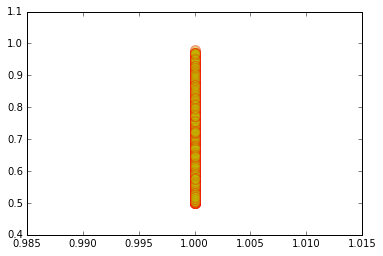

In [71]:
plt.scatter(y_pred_logit[FP_idx], y_proba_logit[:,1][FP_idx], alpha=0.2, s=100, c='y', edgecolor='red')

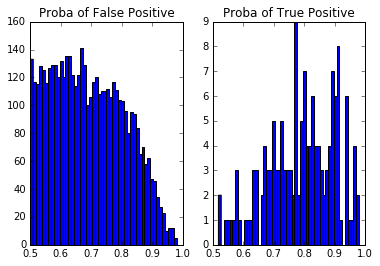

In [72]:
f, ax = plt.subplots(1, 2)
_ = ax[0].hist(y_proba_logit[:,1][FP_idx], bins=50)
ax[0].set_title('Proba of False Positive')
_ = ax[1].hist(y_proba_logit[:,1][TP_idx], bins=50)
ax[1].set_title('Proba of True Positive')

In [73]:
(y_proba_logit[:,1][TP_idx] > 0.75).sum()

98

In [74]:
(y_proba_logit[:,1][FP_idx] > 0.75).sum()

1573

In [75]:
thres = np.linspace(0.2, 1.0, 50)

In [76]:
TPR = []
Precision = []
for t in thres:
    TPR.append((y_proba_logit[:,1][TP_idx] > t).sum() / 179.)
    Precision.append((y_proba_logit[:,1][TP_idx] > t).sum() / ((y_proba_logit[:,1][FP_idx] > t).sum() + (y_proba_logit[:,1][TP_idx] > t).sum()))

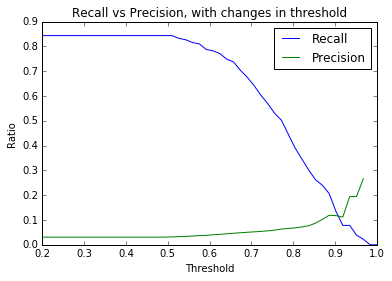

In [83]:
plt.plot(thres, TPR, label='Recall')
plt.plot(thres, Precision, label='Precision')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Ratio')
plt.title('Recall vs Precision, with changes in threshold')

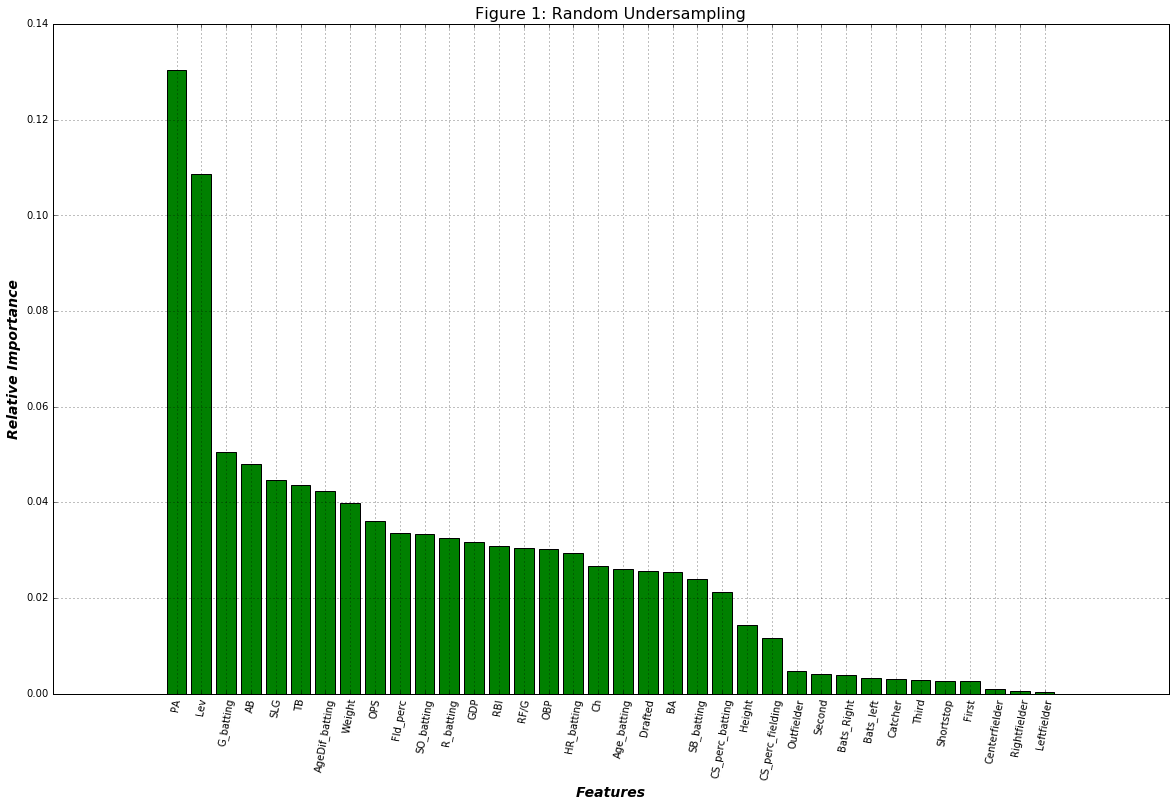

In [78]:

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(20,12))
_ = plt.bar(range(X_train.shape[1]), importances[indices], align='center', label = X_train.columns[indices], color='green')
_ = plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=80)
plt.grid(True)
plt.xlabel('Features', fontsize=14, fontweight='bold', style='italic')
plt.ylabel('Relative Importance', fontsize=14, fontweight='bold', style='italic')
plt.title('Figure 1: Random Undersampling', fontsize=16)



In [79]:
sorted_ix = np.argsort(f_regression(X_resampled, y_resampled)[1])

In [80]:
zip(X_ver2.columns[sorted_ix], f_regression(X_resampled, y_resampled)[1][sorted_ix])

[('PA', 5.4578994325963591e-81),
 ('Lev', 1.2892800823571658e-61),
 ('AB', 3.320448818128424e-35),
 ('G_batting', 7.4391692103487402e-33),
 ('Weight', 4.5339305388633002e-24),
 ('AgeDif_batting', 7.640401893855083e-22),
 ('TB', 2.1489160456792854e-19),
 ('SLG', 7.6390812324013942e-17),
 ('Drafted', 1.6899229652234623e-15),
 ('OPS', 8.9956862207704602e-14),
 ('BA', 1.41101913082364e-10),
 ('OBP', 1.6531066388396548e-09),
 ('Fld_perc', 9.0142308764804544e-08),
 ('SO_batting', 6.2651983383923976e-06),
 ('RF/G', 3.566598904998932e-05),
 ('Ch', 8.3735451609680245e-05),
 ('CS_perc_batting', 0.00066462284932720039),
 ('RBI', 0.0024973858277244168),
 ('CS_perc_fielding', 0.0028967311340555944),
 ('Bats_left', 0.0033319396066397145),
 ('Height', 0.015245409383562294),
 ('Rightfielder', 0.031356076878187492),
 ('Age_batting', 0.037288292472634585),
 ('R_batting', 0.06699327379665726),
 ('Bats_Right', 0.077004488823148712),
 ('GDP', 0.12184913797712868),
 ('Shortstop', 0.14097123942042075),
 ('Ou

In [11]:
pca = PCA()

In [14]:
X_pca = pca.fit_transform(X_ver2)

In [19]:
X_pca

array([[ -1.29783298e+02,  -4.83981924e+01,   3.98907895e+00, ...,
          6.45516250e-01,  -4.50102700e-03,   3.75286410e-01],
       [  2.01940173e+02,  -6.22372208e+01,   4.55601871e+00, ...,
          5.73986062e-01,  -3.40746585e-01,  -2.97053133e-02],
       [  2.01805624e+01,  -5.48349197e+01,   4.22881414e+00, ...,
          6.21953776e-01,  -2.14841097e-01,  -1.58879008e-01],
       ..., 
       [  4.54457377e+02,   2.82727262e+01,  -9.60067199e-01, ...,
         -3.33719005e-01,  -1.92459401e-01,   1.77840715e-02],
       [  1.11461148e+02,   4.24419324e+01,  -1.45920735e+00, ...,
         -3.03398146e-01,   1.52889161e-01,  -1.55354661e-01],
       [ -6.17249683e+01,   4.91054056e+01,  -1.32720482e+00, ...,
         -3.23710419e-01,  -1.29169519e-01,  -9.72408549e-02]])

In [3]:
X_ver2.columns

Index([u'player_id', u'Year', u'AB', u'AgeDif_batting', u'Age_batting', u'BA',
       u'Bats_Right', u'Bats_left', u'CS_perc_fielding', u'Catcher',
       u'Centerfielder', u'Ch', u'Drafted', u'First', u'Fld_perc', u'GDP',
       u'G_batting', u'HR_batting', u'Height', u'Leftfielder', u'Lev', u'OBP',
       u'OPS', u'Outfielder', u'PA', u'RBI', u'RF/G', u'R_batting',
       u'Rightfielder', u'Rookie?', u'SB_batting', u'SLG', u'SO_batting',
       u'Second', u'Shortstop', u'TB', u'Third', u'Weight',
       u'CS_perc_batting'],
      dtype='object')

In [ ]:
_ = scatter_matrix(X_ver2, alpha=0.2, figsize=(6, 6), diagonal='kde')

## Dropping anything AFTER the first promotion year

In [121]:
ix = []
for i, y in X_ver2[X_ver2['Rookie?'] == 1][['player_id', 'Year']].values:
    ix.extend(X_ver2[(X_ver2['player_id'] == i) & (X_ver2['Year'] > y)].index)

In [122]:
len(ix)

3247

In [123]:
X_ver2[X_ver2['Rookie?'] == 1][['player_id', 'Year']].values

array([[11174,  2002],
       [11345,  1999],
       [11459,  2003],
       ..., 
       [38048,  2003],
       [38074,  2002],
       [38084,  2010]])

In [124]:
X_ver2.shape

(82716, 39)

In [125]:
X_ver2 = X_ver2.drop(X_ver2.index[ix])

## Dropping < 1999

In [126]:
X_ver2[X_ver2.Year < 1999].shape

(11849, 39)

In [127]:
X_ver2[X_ver2['Rookie?'] == 1].Year.value_counts()

2010    51
2013    51
1999    49
2000    48
2007    48
2014    44
2005    42
2004    41
2012    41
2009    40
2003    40
2011    37
2008    36
2006    36
2001    36
2002    32
2015    24
Name: Year, dtype: int64

In [128]:
X_ver2 = X_ver2[X_ver2.Year >= 1999]

In [12]:
X_ver2_copy = X_ver2.copy()

In [13]:
Id = X_ver2_copy.pop('player_id')

In [14]:
yeaR = X_ver2_copy.pop('Year')

In [15]:
label = X_ver2_copy.pop('Rookie?')

In [16]:
X_ver2_copy.columns

Index([u'AB', u'AgeDif_batting', u'Age_batting', u'BA', u'Bats_Right',
       u'Bats_left', u'CS_perc_fielding', u'Catcher', u'Centerfielder', u'Ch',
       u'Drafted', u'First', u'Fld_perc', u'GDP', u'G_batting', u'HR_batting',
       u'Height', u'Leftfielder', u'Lev', u'OBP', u'OPS', u'Outfielder', u'PA',
       u'RBI', u'RF/G', u'R_batting', u'Rightfielder', u'SB_batting', u'SLG',
       u'SO_batting', u'Second', u'Shortstop', u'TB', u'Third', u'Weight',
       u'CS_perc_batting'],
      dtype='object')

In [17]:
SScaler = StandardScaler()

In [123]:
X_scaled = SScaler.fit_transform(X_ver2_copy)

In [124]:
df = pd.DataFrame(X_scaled)

In [125]:
df.columns = X_ver2_copy.columns

In [128]:
logit = LogisticRegression()

In [130]:
X_train, X_test, y_train, y_test = train_test_split(df, label)

In [131]:
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_sample(X_train, y_train)

In [132]:
sklogit = LogisticRegression()
RF = RandomForestClassifier(n_estimators=200, n_jobs=4)
GB = GradientBoostingClassifier(n_estimators=500)

In [133]:
sklogit.fit(X_resampled, y_resampled)
RF.fit(X_resampled, y_resampled)
GB.fit(X_resampled, y_resampled)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [134]:
print sklogit.score(X_test, y_test)
print RF.score(X_test, y_test)
print GB.score(X_test, y_test)

0.777173270254
0.81584861029
0.80053222945


In [135]:
y_pred_logit = sklogit.predict(X_test)
y_pred_RF = RF.predict(X_test)
y_pred_GB = GB.predict(X_test)
y_proba_logit = sklogit.predict_proba(X_test)
y_proba_RF = RF.predict_proba(X_test)
y_proba_GB = GB.predict_proba(X_test)

In [136]:
print precision_score(y_test, y_pred_logit)
print precision_score(y_test, y_pred_RF)
print precision_score(y_test, y_pred_GB)

0.0369609856263
0.0418734491315
0.0387596899225


In [137]:
print recall_score(y_test, y_pred_logit)
print recall_score(y_test, y_pred_RF)
print recall_score(y_test, y_pred_GB)

0.9
0.84375
0.84375


In [138]:
print roc_auc_score(y_test, y_pred_logit)
print roc_auc_score(y_test, y_pred_RF)
print roc_auc_score(y_test, y_pred_GB)

0.838
0.829666044776
0.821934701493


In [237]:
a = confusion_matrix(y_test, y_pred_logit)

In [242]:
a[1:,1]

array([144])

In [140]:
sorted_ix = np.argsort(f_regression(X_resampled, y_resampled)[1])

In [141]:
zip(X_ver2.columns[sorted_ix], f_regression(X_resampled, y_resampled)[1][sorted_ix])

[('OPS', 9.9314820060527313e-82),
 ('Height', 8.3204172128554438e-54),
 ('player_id', 8.0184488398939992e-46),
 ('Fld_perc', 3.3791376016811248e-44),
 ('SO_batting', 2.4716249614484259e-28),
 ('Year', 3.6341533294525168e-24),
 ('Centerfielder', 3.4371266890748303e-15),
 ('Shortstop', 1.165900136839157e-14),
 ('Rightfielder', 2.9147813917918445e-14),
 ('Lev', 6.7711558131511608e-12),
 ('AgeDif_batting', 1.3610420288869321e-10),
 ('Leftfielder', 1.6084767593806585e-08),
 ('Catcher', 1.8880138774376296e-08),
 ('TB', 4.0526180465229493e-07),
 ('Rookie?', 6.2069020466591378e-07),
 ('Drafted', 0.00051473156895198268),
 ('Outfielder', 0.0075244992064674009),
 ('RBI', 0.018157077620405155),
 ('First', 0.02171398581862705),
 ('CS_perc_fielding', 0.026271457462050417),
 ('PA', 0.039247920480791738),
 ('OBP', 0.075818838868797103),
 ('Age_batting', 0.09438154607883166),
 ('SLG', 0.099330417187882644),
 ('RF/G', 0.19651943490048912),
 ('G_batting', 0.23051918404719984),
 ('HR_batting', 0.312050221

curr_lev - prev_lev

In [144]:
X_ver2 = X_ver2.drop('PA', axis=1)

In [129]:
X_ver2[['BA_diff', 'Fld_per_diff', 'GDP_diff', 'HR_batting_diff', 'OBP_diff', 'OPS_diff', 'RBI_diff', 'RF/G_diff', 'R_batting_diff', 'TB_diff', 'SO_batting_diff', 'CS_per_batting_diff']] =\
X_ver2[['BA', 'Fld_perc', 'GDP', 'HR_batting', 'OBP', 'OPS', 'RBI', 'RF/G', 'R_batting', 'TB', 'SO_batting', 'CS_perc_batting']]

## Lets make a copy before doing some crazy stuff

In [163]:
copy_before_new_col = X_ver2.copy()

In [130]:
group_idx = X_ver2.groupby('player_id').groups.values()

In [131]:
for group in group_idx:
    print group
    break

[0, 1, 2]


In [132]:
for group in group_idx:
    for i, idx in enumerate(group):
        if i == 0:
            X_ver2.set_value(idx, ['BA_diff', 'Fld_per_diff', 'GDP_diff',
                                           'HR_batting_diff', 'OBP_diff', 'OPS_diff',
                                           'RBI_diff', 'RF/G_diff', 'R_batting_diff',
                                           'TB_diff', 'SO_batting_diff', 'CS_per_batting_diff'], 0)
        else:
            X_ver2.set_value(idx, ['BA_diff', 'Fld_per_diff', 'GDP_diff',
                                           'HR_batting_diff', 'OBP_diff', 'OPS_diff',
                                           'RBI_diff', 'RF/G_diff', 'R_batting_diff',
                                           'TB_diff', 'SO_batting_diff', 'CS_per_batting_diff'],
                             X_ver2.ix[idx][['BA', 'Fld_perc', 'GDP', 'HR_batting', 'OBP', 'OPS',
                                             'RBI', 'RF/G', 'R_batting', 'TB', 'SO_batting',
                                             'CS_perc_batting']].values -\
                             X_ver2.ix[idx-1][['BA', 'Fld_perc', 'GDP', 'HR_batting', 'OBP', 'OPS',
                                             'RBI', 'RF/G', 'R_batting', 'TB', 'SO_batting',
                                             'CS_perc_batting']].values)

In [133]:
X_ver2.to_csv('X_808.csv')

In [753]:
def gbplot_pie(fractions, #values for the wedges
              labels, #labels for the wedges
              title = '', #title of the pie chart
              cm_name = 'Pastel1', #name of the matplotlib colormap to use
              autopct = '%1.1f%%', #format the value text on each pie wedge
              labeldistance = 1.05, #where to place wedge labels in relation to pie wedges
              shadow = True, #shadow around the pie
              startangle = 90, #rotate 90 degrees to start the top of the data set on the top of the pie
              edgecolor = 'w', #color of pie wedge edges
              width = 8, #width of the figure in inches
              height = 8, #height of the figure in inches
              grouping_threshold = None, #group all wedges below this value into one 'all others' wedge
              grouping_label = None): #what the label the grouped wedge
    
    # if the user passed a threshold value, group all fractions lower than it into one 'misc' pie wedge
    if not grouping_threshold==None:
        
        # if user didn't pass a label, apply a default text
        if grouping_label == None:
            grouping_label = 'Others'

        # select the rows greater than the cutoff value
        row_mask = fractions > grouping_threshold
        meets_threshold = fractions[row_mask]

        # group all other rows below the cutoff value
        all_others = pd.Series(fractions[~row_mask].sum())
        all_others.index = [grouping_label]

        # append the grouped row to the bottom of the rows to display
        fractions = meets_threshold.append(all_others)
        labels = fractions.index
    
    # get the color map then pull 1 color from it for each pie wedge we'll draw
    color_map = cm.get_cmap(cm_name)
    num_of_colors = len(fractions)
    colors = color_map([x/float(num_of_colors) for x in range(num_of_colors)])
    
    # create the figure and an axis to plot on
    fig, ax = plt.subplots(figsize=[width, height])
    
    # plot the pie
    wedges = ax.pie(fractions, 
                    
                    labeldistance = labeldistance,
                    autopct = autopct,
                    colors = ['#fc5a50', colors[1]],
                    shadow = shadow,
                    explode=(0, 0.2),
                    startangle = startangle,
                   textprops={'weight':'bold', 'fontsize': 18, 'fontname': 'monospace'})
    plt.title('Batters:\nPromoted to majors next year?', fontweight='bold', fontsize=20, fontname='monospace')
    # change the edgecolor for each wedge
    for wedge in wedges[0]:
        wedge.set_edgecolor(edgecolor)
    plt.legend(['No', 'Yes'], loc="best", fontsize=16)
    # set the title and show the plot
    #ax.set_title(title, fontproperties=title_font)
    plt.show()

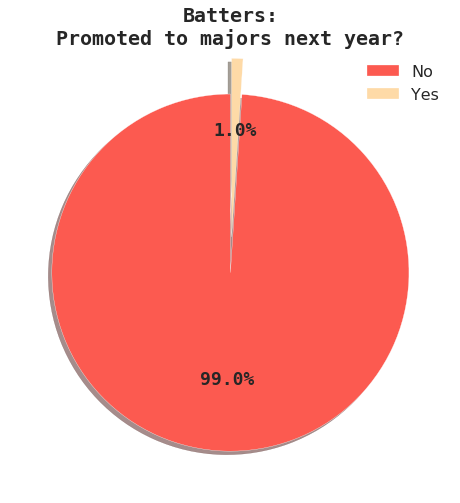

In [754]:
gbplot_pie(fractions = X_ver2['Rookie?'].value_counts(),
           labels=['No', 'Yes'],
           title = 'Cities, by share of records in data set',
           
           grouping_label = 'All Other Cities')

In [134]:
X_ver2_bat = X_ver2.drop(['player_id', 'Year'], axis=1)

In [135]:
y = X_ver2_bat.pop('Rookie?')

In [247]:
X_train, X_test, y_train, y_test = train_test_split(X_ver2_bat, y)

In [248]:
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_sample(X_train, y_train)

In [251]:
sm = SMOTE(kind='regular')
X_over, y_over = sm.fit_sample(X_train, y_train)

In [252]:
d = {'Regular': [X_train, y_train], 'SMOTE': [X_over, y_over], 'Undersampling': [X_resampled, y_resampled]}

In [253]:
y_test_copy = y_test.copy()

In [254]:
y_test_copy.index = range(y_test_copy.shape[0])

In [255]:
true_idx_0 = y_test_copy[y_test_copy == 0].index

In [256]:
true_idx_1 = y_test_copy[y_test_copy==1].index

In [257]:
thres = np.linspace(0.0, 1.0, 100)

In [462]:
acc_logit = []
acc_RF = []
acc_GB = []
prec_logit = []
prec_RF = []
prec_GB = []
rec_logit = []
rec_RF = []
rec_GB = []
auc_logit = []
auc_RF = []
auc_GB = []
CM_logit = []
CM_RF = []
CM_GB = []
roc_logit = []
roc_RF = []
roc_GB = []
for tpe in d:
    X_x, y_y = d[tpe]
    sklogit = LogisticRegression()
    RF = RandomForestClassifier(n_estimators=200, n_jobs=4)
    GB = GradientBoostingClassifier(n_estimators=500)
    sklogit.fit(X_x, y_y)
    RF.fit(X_x, y_y)
    GB.fit(X_x, y_y)
    acc_logit.append(sklogit.score(X_test, y_test))
    acc_RF.append(RF.score(X_test, y_test))
    acc_GB.append(GB.score(X_test, y_test))
    y_pred_logit = sklogit.predict(X_test)
    y_pred_RF = RF.predict(X_test)
    y_pred_GB = GB.predict(X_test)
    y_proba_logit = sklogit.predict_proba(X_test)
    y_proba_RF = RF.predict_proba(X_test)
    y_proba_GB = GB.predict_proba(X_test)
    prec_logit.append(precision_score(y_test, y_pred_logit))
    prec_RF.append(precision_score(y_test, y_pred_RF))
    prec_GB.append(precision_score(y_test, y_pred_GB))
    rec_logit.append(recall_score(y_test, y_pred_logit))
    rec_RF.append(recall_score(y_test, y_pred_RF))
    rec_GB.append(recall_score(y_test, y_pred_GB))
    auc_logit.append(roc_auc_score(y_test, y_pred_logit))
    auc_RF.append(roc_auc_score(y_test, y_pred_RF))
    auc_GB.append(roc_auc_score(y_test, y_pred_GB))
    CM_logit.append(confusion_matrix(y_test, y_pred_logit))
    CM_RF.append(confusion_matrix(y_test, y_pred_RF))
    CM_GB.append(confusion_matrix(y_test, y_pred_GB))
    auc_logit.append(roc_curve(y_test, y_pred_logit))
    auc_RF.append(roc_curve(y_test, y_pred_RF))
    auc_GB.append(roc_curve(y_test, y_pred_GB))
    '''
    importances = RF.feature_importances_
    indices = np.argsort(importances)[::-1]
    fig1 = plt.figure(figsize=(20,12))
    _ = plt.bar(range(X_train.shape[1]), importances[indices], align='center', label = X_train.columns[indices], color='green')
    _ = plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=80)
    plt.grid(True)
    plt.xlabel('Features', fontsize=14, fontweight='bold', style='italic')
    plt.ylabel('Relative Importance', fontsize=14, fontweight='bold', style='italic')
    plt.title('Batting_'+tpe, fontsize=16)
    fig1.savefig('/home/jun/Galvanize/capstone/Galvanize_capstone/Images/Presentation/Bat/featimp_%s.png' % tpe)
    plt.close(fig1)
    
    for y_set in [[y_pred_logit, y_proba_logit, 'Logistic Regression'], [y_pred_RF, y_proba_RF, 'Random Forest'], [y_pred_GB, y_proba_GB, 'Gradient Boosting']]:
        y_pred, y_proba, model_name = y_set
        TP = confusion_matrix(y_test, y_pred)[1:,1]
        pred_idx_1 = np.where(y_pred == 1)
        pred_idx_0 = np.where(y_pred == 0)
        FP_idx = np.intersect1d(true_idx_0, pred_idx_1)
        TP_idx = np.intersect1d(true_idx_1, pred_idx_1)
        TPR = []
        Precision = []
        for t in thres:
            TPR.append((y_proba[:,1][TP_idx] > t).sum() / TP)
            Precision.append((y_proba[:,1][TP_idx] > t).sum() / ((y_proba[:,1][FP_idx] > t).sum() + (y_proba[:,1][TP_idx] > t).sum()))
        fig = plt.figure()
        plt.plot(thres, TPR, label='Recall')
        plt.plot(thres, Precision, label='Precision')
        plt.legend()
        plt.xlabel('Threshold')
        plt.ylabel('Ratio')
        plt.title('Batters: ' + tpe + ' + ' + model_name)
        fig.savefig('/home/jun/Galvanize/capstone/Galvanize_capstone/Images/Presentation/Bat/%s.png' % (tpe + '_' + model_name + '_batters'))
        plt.close(fig)'''

In [259]:
acc_under = [acc_logit[0], acc_RF[0], acc_GB[0]]
acc_reg = [acc_logit[1], acc_RF[1], acc_GB[1]]
acc_SMOTE = [acc_logit[2], acc_RF[2], acc_GB[2]]

rec_under = [rec_logit[0], rec_RF[0], rec_GB[0]]
rec_reg = [rec_logit[1], rec_RF[1], rec_GB[1]]
rec_SMOTE = [rec_logit[2], rec_RF[2], rec_GB[2]]

prec_under = [prec_logit[0], prec_RF[0], prec_GB[0]]
prec_reg = [prec_logit[1], prec_RF[1], prec_GB[1]]
prec_SMOTE = [prec_logit[2], prec_RF[2], prec_GB[2]]

auc_under = [auc_logit[0], auc_RF[0], auc_GB[0]]
auc_reg = [auc_logit[1], auc_RF[1], auc_GB[1]]
auc_SMOTE = [auc_logit[2], auc_RF[2], auc_GB[2]]

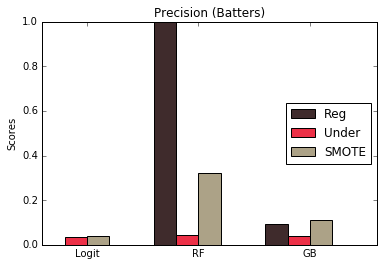

In [268]:
N = 3

ind = np.arange(N)  # the x locations for the groups
width = 0.20       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, prec_reg, width, color='#3f2b2c')

rects2 = ax.bar(ind + width, prec_under, width, color='#ec3047')

rects3 = ax.bar(ind + width + width, prec_SMOTE, width, color='#aca287')

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Precision (Batters)')
ax.set_xticks(ind + width + width)
ax.set_xticklabels(('Logit', 'RF', 'GB'))

ax.legend((rects1[0], rects2[0], rects3[0]), ('Reg', 'Under', 'SMOTE'), loc='right')
fig.savefig('/home/jun/Galvanize/capstone/Galvanize_capstone/Images/Presentation/Bat/Prec_bat.png')

In [231]:
len(X_ver2.columns)

50

In [286]:
RF_806 = RandomForestClassifier(n_estimators=200, class_weight='balanced')

In [287]:
RF_806.fit(X_over, y_over)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [288]:
y_pred_806 = logit_806.predict(X_test)

In [289]:
precision_score(y_test, y_pred_806)

0.037434627030002755

In [290]:
recall_score(y_test, y_pred_806)

0.80473372781065089

In [ ]:
u'Fld_perc', u'GDP', u'OBP', u'OPS', u'SLG', u'R_batting_diff',
       u'CS_per_batting_diff'


In [227]:
X_ver2_808 = X_ver2.copy()

In [228]:
X_ver2_808 = X_ver2_808.drop(['CS_per_batting_diff', 'R_batting_diff'], axis=1)

In [229]:
X_ver2_808['ISO'] = X_ver2_808['SLG'] - X_ver2_808['BA']

In [230]:
X_ver2_808 = X_ver2_808.drop('SLG', axis=1)

In [231]:
X_ver2_808 = X_ver2_808.drop('OPS', axis=1)

In [232]:
X_ver2_808 = X_ver2_808.drop('CS_perc_batting', axis=1)

In [233]:
X_ver2_808x = X_ver2_808.drop(['player_id', 'Year', 'Rookie?', 'GDP'], axis=1)

In [234]:
X_ver2_808x = X_ver2_808x.drop('AB', axis=1)

In [ ]:
X_ver2_808x = X_ver2_808x.drop(['HR_batting', 'Ch', ''])

In [235]:
X_ver2_808x.shape

(67638, 42)

In [238]:
y.shape

(67638,)

In [239]:
BA', u'Bats_Right', u'Bats_left', u'CS_perc_fielding',
       u'Centerfielder', u'Ch', u'First', u'Fld_perc', u'HR_batting',
       u'Height', u'Leftfielder', u'OBP', u'Outfielder', u'PA', u'RBI',
       u'R_batting', u'Rightfielder', u'SB_batting', u'SO_batting', u'Third',
       u'Weight', u'BA_diff', u'Fld_per_diff', u'GDP_diff', u'HR_batting_diff',
       u'OBP_diff', u'OPS_diff', u'RBI_diff', u'RF/G_diff', u'SO_batting_diff',
       u'ISO'

IndentationError: unexpected indent (<ipython-input-239-6290f16e26bf>, line 2)

In [428]:
X_train_808, X_test_808, y_train_808, y_test_808 = train_test_split(X_ver2_808x, y, train_size=0.8)
sm = SMOTE(kind = 'regular')
RU = RandomUnderSampler(ratio=0.5)

In [431]:
X_over_808, y_over_808 = sm.fit_sample(X_train_808, y_train_808)
X_under_808, y_under_808 = RU.fit_sample(X_train_808, y_train_808)

In [432]:
X_under_808

array([[ -6.00000000e-01,   2.40000000e+01,   7.01489362e-01, ...,
         -1.15036646e-01,   4.95526867e-03,   1.28191489e-01],
       [  1.35000000e+00,   2.70000000e+01,   6.04314815e-01, ...,
          8.56867261e-02,   6.22568056e-04,   2.66598765e-01],
       [ -3.90000000e+00,   2.30000000e+01,   5.77343750e-01, ...,
         -7.50083287e-02,   2.72872812e-03,   2.03812500e-01],
       ..., 
       [ -4.00000000e-01,   1.80000000e+01,   2.65000000e-01, ...,
          4.17092941e-02,  -3.02900732e-04,   4.40000000e-02],
       [  1.50000000e+00,   2.30000000e+01,   3.09000000e-01, ...,
          2.05450809e-01,  -8.30689545e-04,   1.91000000e-01],
       [  1.00000000e+00,   2.50000000e+01,   2.39000000e-01, ...,
          4.01343140e-02,   2.12414942e-03,   1.20000000e-01]])

In [433]:
x_under_808df = pd.DataFrame(X_under_808)

In [434]:
x_under_808df.columns = X_ver2_808x.columns

In [435]:
stats_logit = Logit(y_under_808, x_under_808df).fit()

Optimization terminated successfully.
         Current function value: 0.374795
         Iterations 12


In [518]:
def results_summary_to_dataframe(results):
    '''This takes the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"pvals":pvals,
                               "coeff":coeff,
                               "conf_lower":conf_lower,
                               "conf_higher":conf_higher
                                })

    #Reordering...
    results_df = results_df[["coeff","pvals","conf_lower","conf_higher"]]
    return results_df

In [521]:
results_summary_to_dataframe(stats_logit)

,coeff,pvals,conf_lower,conf_higher
AgeDif_batting,0.179670,3.886973e-03,0.057701,0.301638
Age_batting,-0.409881,1.000093e-15,-0.509964,-0.309798
BA,-2.733539,3.368555e-01,-8.312106,2.845028
Bats_Right,-0.166939,4.689655e-01,-0.618763,0.284885
Bats_left,-0.027365,9.160001e-01,-0.535871,0.481142
CS_perc_fielding,0.011654,1.028410e-01,-0.002349,0.025658
Catcher,1.029190,3.934097e-03,0.329607,1.728773
Centerfielder,0.367674,4.572051e-01,-0.601620,1.336968
Ch,1.407166,5.140584e-03,0.421495,2.392837
Drafted,-0.004614,1.708409e-02,-0.008406,-0.000822


In [437]:
bad_ix = np.where(stats_logit.pvalues >= 0.05)

In [438]:
X_ver2_808x.columns[38]

'RF/G_diff'

In [439]:
X_ver2_808x.columns[bad_ix]

Index([u'BA', u'Bats_Right', u'Bats_left', u'CS_perc_fielding',
       u'Centerfielder', u'First', u'Fld_perc', u'G_batting', u'HR_batting',
       u'Leftfielder', u'OBP', u'Outfielder', u'RBI', u'R_batting',
       u'Rightfielder', u'Second', u'Third', u'BA_diff', u'Fld_per_diff',
       u'GDP_diff', u'HR_batting_diff', u'OBP_diff', u'OPS_diff', u'RBI_diff',
       u'RF/G_diff', u'SO_batting_diff', u'ISO'],
      dtype='object')

In [544]:
sklogit = LogisticRegression()
RF = RandomForestClassifier(n_estimators=200, n_jobs=4)

In [545]:
sklogit.fit(X_under_808, y_under_808)
RF.fit(X_under_808, y_under_808)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [546]:
print sklogit.score(X_test_808, y_test_808)
print RF.score(X_test_808, y_test_808)

0.989281490242
0.88638379657


In [547]:
y_pred_logit = sklogit.predict(X_test_808)
y_pred_RF = RF.predict(X_test_808)
y_proba_logit = sklogit.predict_proba(X_test_808)
y_proba_RF = RF.predict_proba(X_test_808)

In [548]:
print precision_score(y_test_808, y_pred_logit)
print precision_score(y_test_808, y_pred_RF)

0.0
0.065543071161


In [549]:
print recall_score(y_test_808, y_pred_logit)
print recall_score(y_test_808, y_pred_RF)

0.0
0.724137931034


In [550]:
print roc_auc_score(y_test_808, y_pred_logit)
print roc_auc_score(y_test_808, y_pred_RF)

0.5
0.806139801653


In [529]:
11483 + 1900 + 31 + 114

13528

In [552]:
13383 / 13528

0.98928149024246

In [551]:
confusion_matrix(y_test_808, y_pred_logit)

array([[13383,     0],
       [  145,     0]])

In [466]:
cross_val_score(sklogit, X_under_808, y_under_808, cv=10, scoring='recall').mean()

0.76230519480519487

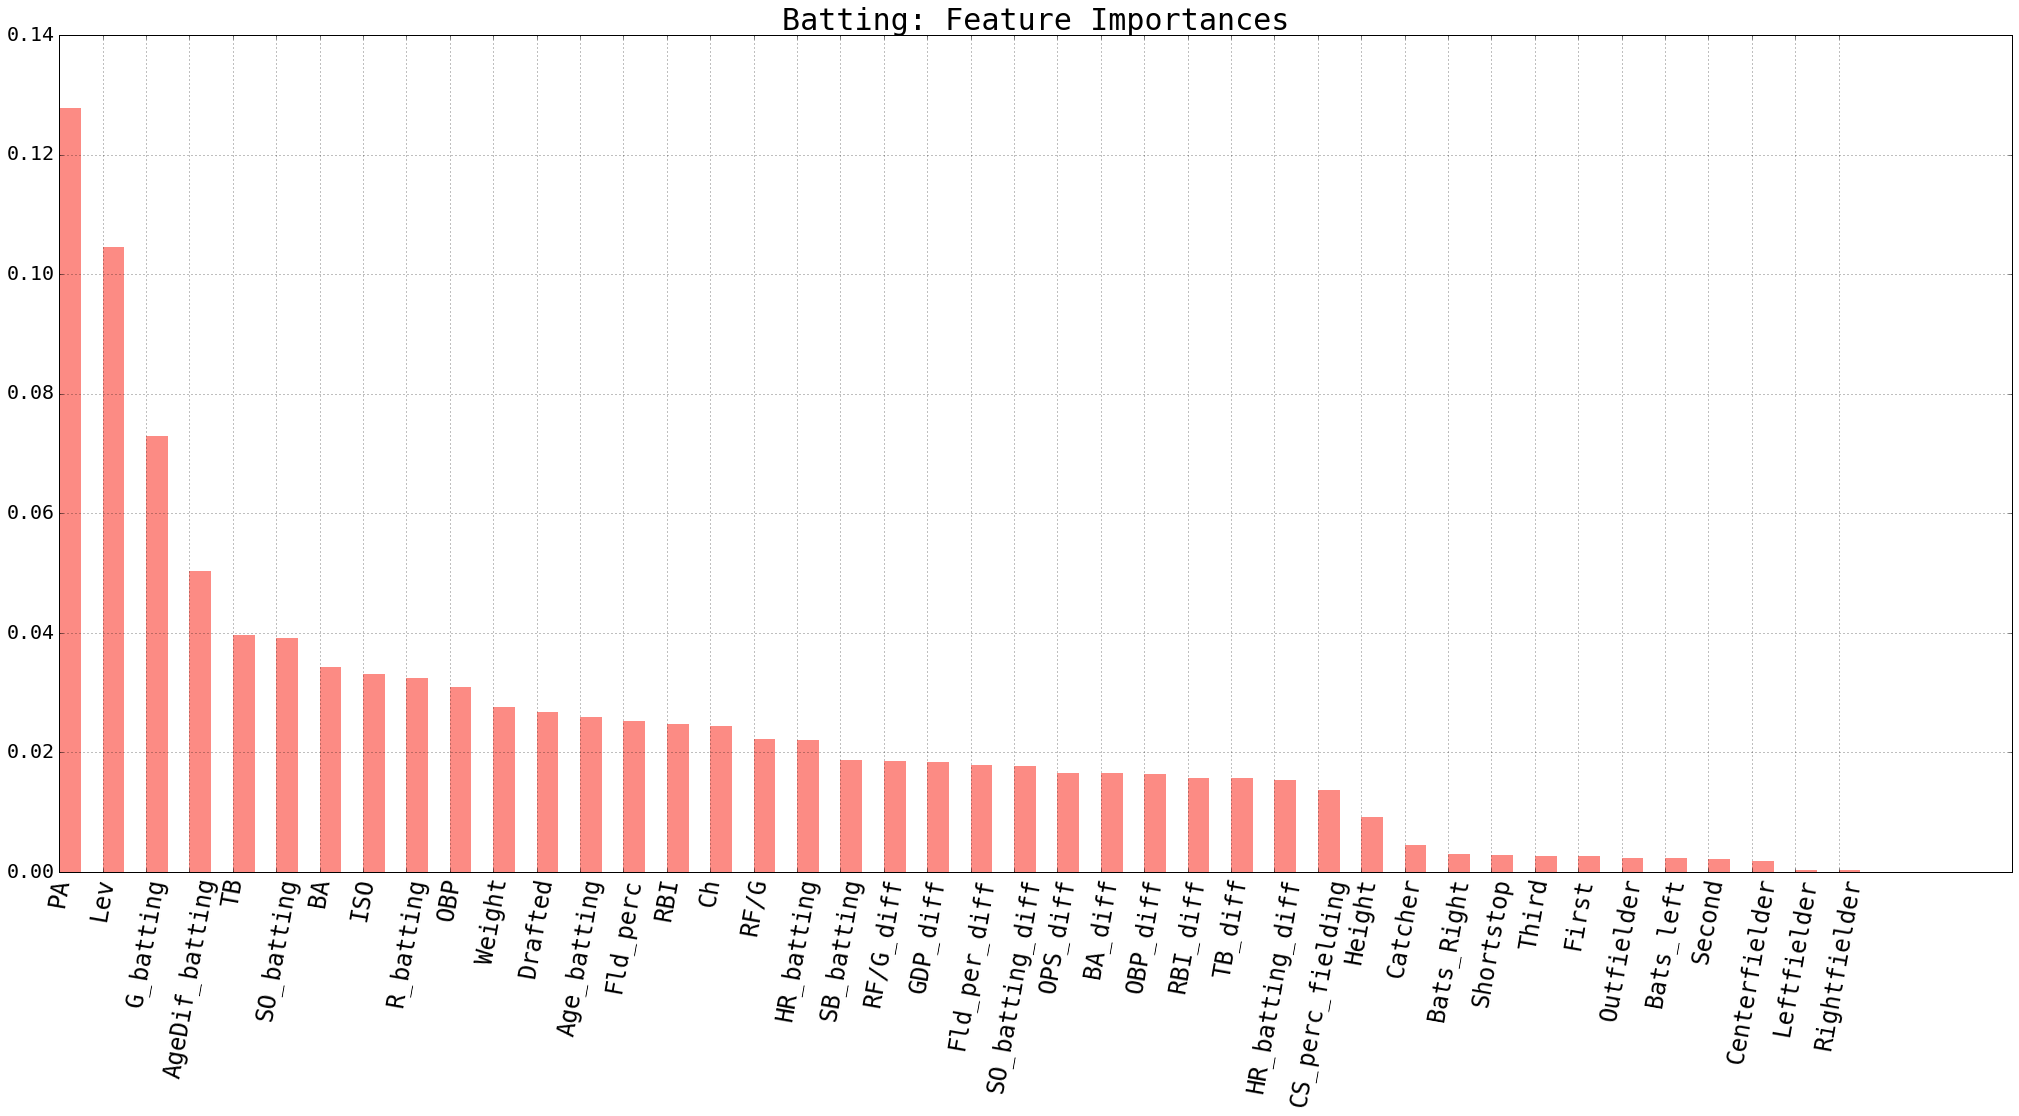

In [580]:
importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(35,15))
_ = plt.bar(range(X_train_808.shape[1]), importances[indices],  0.5, label = X_train_808.columns[indices], color='#fc5a50',
           edgecolor=None, linewidth=0, alpha=0.7)
_ = plt.xticks(range(X_train_808.shape[1]), X_train_808.columns[indices], rotation=80, fontsize=24, fontname='monospace')
_ = plt.yticks(fontname='monospace', fontsize=20)
plt.grid(True)
#plt.xlabel('Features', fontsize=14, fontweight='bold', style='italic')
#plt.ylabel('Relative Importance', fontsize=16, fontweight='bold', style='italic')
plt.title('Batting: Feature Importances', fontsize=30, fontname='monospace')

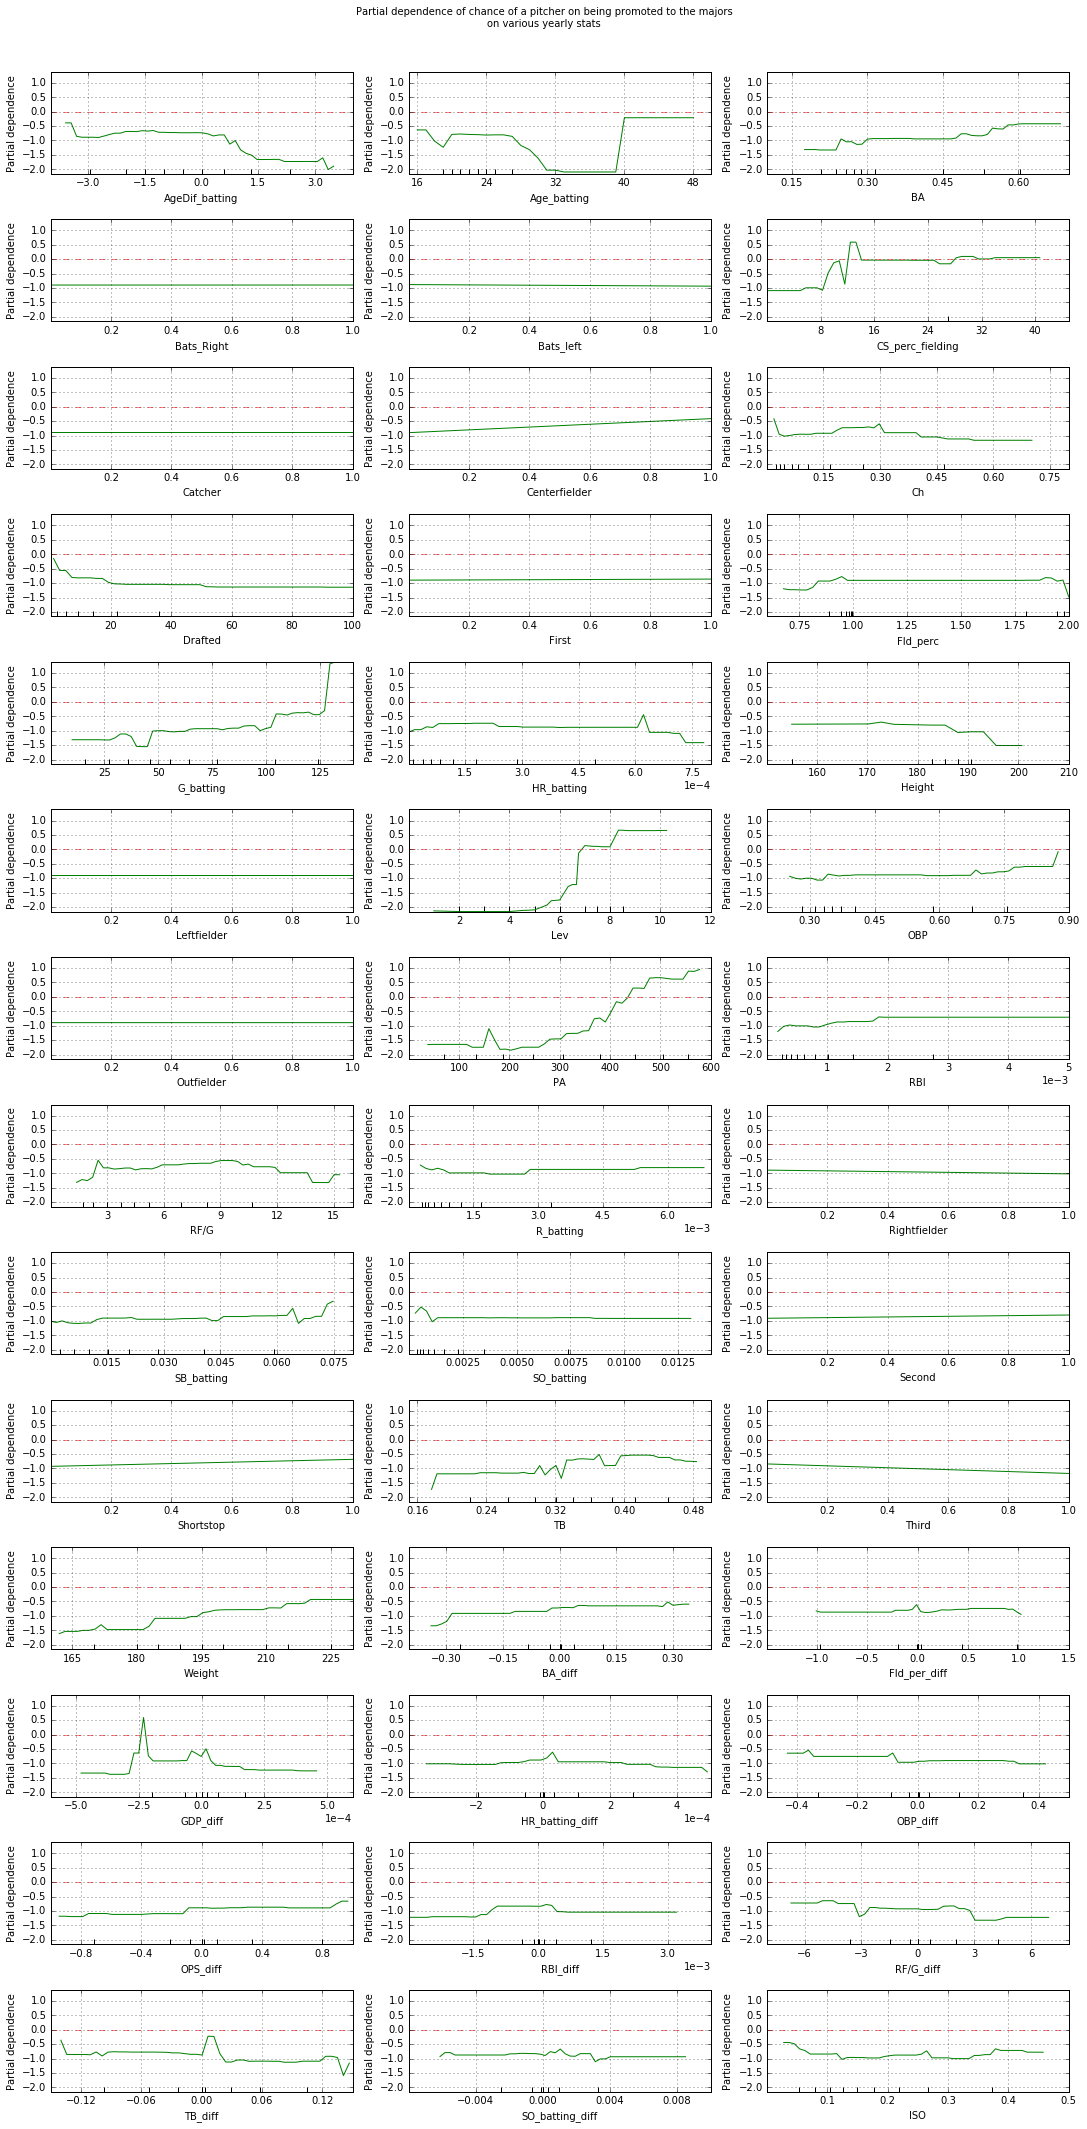

In [553]:
##### features = range(len(X.columns))
grbt = GradientBoostingClassifier(n_estimators=500)
grbt.fit(X_under_808, y_under_808)
names = X_ver2_808x.columns
features = range(len(X_ver2_808x.columns))
fig, axs = plot_partial_dependence(grbt, X_under_808, features,
                                   feature_names=names,
                                   n_jobs=4, grid_resolution=50, figsize=(15, 30),
                                   )
fig.suptitle('Partial dependence of chance of a pitcher on being promoted to the majors\n'
             'on various yearly stats')
for axes in axs:
    axes.grid(True)
    axes.axhline(0, linestyle='--', color='#ff8080')
    axes

plt.tight_layout(pad=0.4)
plt.subplots_adjust(top=0.95) 

In [626]:
X_ver2_808x.columns[bad_ix]

Index([u'Bats_Right'], dtype='object')

In [567]:
y_pred_lass

array([ 0.5,  0.5,  0.5, ...,  0.5,  0.5,  0.5])

In [330]:
y[y == 0].index

Int64Index([    0,     1,     2,     3,     4,    15,    16,    17,    18,
               19,
            ...
            82699, 82700, 82701, 82709, 82710, 82711, 82712, 82713, 82714,
            82715],
           dtype='int64', length=66942)

In [337]:
X_ver2_bat.HR_batting.describe()

count    67638.000000
mean         0.000251
std          0.001512
min          0.000000
25%          0.000005
50%          0.000070
75%          0.000184
max          0.111111
Name: HR_batting, dtype: float64

In [380]:
X_ver2[X_ver2['HR_batting'] > 0.003]['Rookie?'].value_counts()

0.0    613
1.0      3
Name: Rookie?, dtype: int64

In [383]:
MLB_batters = pd.read_csv('/home/jun/Galvanize/capstone/Galvanize_capstone/Data/Team_stats/batting.csv')

In [389]:
raw_bat = pd.read_csv('/home/jun/Galvanize/capstone/Galvanize_capstone/Data/Players/batters.csv')

In [430]:
raw_bat2 = X_ver2.merge(onlypart_raw[['player_id', 'Year', 'Aff_batting']], how='left', on=['player_id', 'Year'])

In [431]:
X_ver2.shape

(67638, 50)

In [404]:
id_ = pd.read_csv('/home/jun/Galvanize/capstone/Galvanize_capstone/Data/Players/id.csv')

In [437]:
id_[id_.player_id == 26]

,index,player_id,Name
26,0,26,Jeff Christy


In [409]:
onlypart_raw = raw_bat[['player_id', 'Year', 'Aff_batting']]

In [410]:
onlypart_raw = onlypart_raw[onlypart_raw.Aff_batting.notnull()]

In [418]:
onlypart_raw = onlypart_raw.drop_duplicates(keep='last')

In [423]:
onlypart_raw = onlypart_raw.drop_duplicates(['player_id', 'Year'], keep='last')

In [439]:
raw_bat3 = raw_bat2[raw_bat2.Aff_batting.notnull()]

In [440]:
raw_bat3.shape

(57772, 51)

In [ ]:
some = raw_bat3.merge(MLB_batters, how='left', left_on=['Year', 'Aff_pitching', 'Role'], right_on = ['yearID', 'teamID', 'POS'], suffixes=['_Minor', '_MLB'])

In [452]:
bins = np.arange(-100, 100, 5)
for column in X_ver2_bat.loc[:,X_ver2_bat.dtypes!=object].columns:
    fig = plt.figure(figsize=(12, 8))
    _ = plt.hist(X_ver2[X_ver2['Rookie?'] == 1][column].dropna(), bins=70, stacked=True, alpha=0.4, label='Making majors', normed=True, color='#ff0066')
    _ = plt.hist(X_ver2[X_ver2['Rookie?'] == 0][column].dropna(), bins=100, stacked=True, alpha=0.4, label='Not making majors', normed=True, color='#0099ff')
    plt.title(column, fontsize=13, fontweight='bold')
    plt.xlabel(column, fontsize=12, fontweight='bold', style='italic')
    plt.ylabel('Normed Value', fontsize=12, fontweight='bold', style='italic')
    plt.legend()
    name = '_'.join(column.split('/'))
    fig.savefig('/home/jun/Galvanize/capstone/Galvanize_capstone/Images/Hist/%s_hist.png' % name)
    plt.close(fig)
    
   
    print column

AB
AgeDif_batting
Age_batting
BA
Bats_Right
Bats_left
CS_perc_fielding
Catcher
Centerfielder
Ch
Drafted
First
Fld_perc
GDP
G_batting
HR_batting
Height
Leftfielder
Lev
OBP
OPS
Outfielder
RBI
RF/G
R_batting
Rightfielder
SB_batting
SLG
SO_batting
Second
Shortstop
TB
Third
Weight
CS_perc_batting
BA_diff
Fld_per_diff
GDP_diff
HR_batting_diff
OBP_diff
OPS_diff
RBI_diff
RF/G_diff
R_batting_diff
TB_diff
SO_batting_diff
CS_per_batting_diff


In [454]:
bins = np.arange(-100, 100, 5)
for column in X_ver2_bat.loc[:,X_ver2_bat.dtypes!=object].columns:
    fig = plt.figure(figsize=(12, 8))
    _ = plt.scatter(X_ver2[column].values, y, alpha=0.1, facecolor='y', edgecolor='r', s=70)
    #plt.colorbar()
    plt.title(column + ' vs ' + 'MakeMajors', fontsize=13, fontweight='bold')
    plt.xlabel(column, fontsize=12, fontweight='bold', style='italic')
    plt.ylabel('Make Majors', fontsize=12, fontweight='bold', style='italic')
    name = '_'.join(column.split('/'))
    fig.savefig('/home/jun/Galvanize/capstone/Galvanize_capstone/Images/Scatter/%s_scatter.png' % name)
    plt.close(fig)
   
    print column


AB
AgeDif_batting
Age_batting
BA
Bats_Right
Bats_left
CS_perc_fielding
Catcher
Centerfielder
Ch
Drafted
First
Fld_perc
GDP
G_batting
HR_batting
Height
Leftfielder
Lev
OBP
OPS
Outfielder
RBI
RF/G
R_batting
Rightfielder
SB_batting
SLG
SO_batting
Second
Shortstop
TB
Third
Weight
CS_perc_batting
BA_diff
Fld_per_diff
GDP_diff
HR_batting_diff
OBP_diff
OPS_diff
RBI_diff
RF/G_diff
R_batting_diff
TB_diff
SO_batting_diff
CS_per_batting_diff


In [470]:
wage = [1150*6, 1300*6, 1500*6, 1700*6, 2150*6, 507500] 

In [476]:
labels = ['Short Season', 'Low A', 'High A', 'AA', 'AAA', 'MLB']
y_pos = np.arange(len(labels))

In [493]:
def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

In [498]:
CM_logit

[array([[13048,  3693],
        [   35,   134]]), array([[16740,     1],
        [  169,     0]]), array([[13244,  3497],
        [   33,   136]])]

In [499]:
CM_logit[0]

array([[13048,  3693],
       [   35,   134]])

In [509]:
16740 + 1 + 169

16910

In [521]:
169 / 16910.

0.009994086339444116

In [519]:
CM_logit[1]

array([[16740,     1],
       [  169,     0]])

In [501]:
TN = CM_logit[1][0, 0]

In [503]:
TP = CM_logit[1][1, 1]

In [504]:
FP = CM_logit[1][0, 1]
FN = CM_logit[1][1, 0]

In [ ]:
acc_under = [acc_logit[0], acc_RF[0], acc_GB[0]]
acc_reg = [acc_logit[1], acc_RF[1], acc_GB[1]]
acc_SMOTE = [acc_logit[2], acc_RF[2], acc_GB[2]]

In [524]:
X_ver2.head()

,player_id,Year,AB,AgeDif_batting,Age_batting,BA,Bats_Right,Bats_left,CS_perc_fielding,Catcher,...,GDP_diff,HR_batting_diff,OBP_diff,OPS_diff,RBI_diff,RF/G_diff,R_batting_diff,TB_diff,SO_batting_diff,CS_per_batting_diff
0,2,2004,255.0,0.6,22.0,0.259000,1.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2,2005,444.0,1.1,23.0,0.277000,1.0,0.0,0.0,0.0,...,-0.000067,0.000010,0.026000,0.060000,-0.000053,1.157500,-0.000170,0.026706,-0.000465,0.059259
2,2,2006,187.0,0.4,24.0,0.460235,1.0,0.0,0.0,0.0,...,0.000053,0.000021,0.242219,0.454588,0.000086,4.148119,0.000355,-0.093181,0.000763,0.125767
3,3,2005,117.0,0.8,22.0,0.239000,1.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,3,2006,93.0,1.2,23.0,0.247000,1.0,0.0,0.0,0.0,...,0.000309,-0.000072,-0.016000,-0.044000,0.000753,-0.635000,0.000599,-0.014706,-0.000642,1.000000


In [742]:
def histpair(x, y, bins=None, xmin=None, xmax=None, normed=1, alpha=0.2, figsize=(12,8), title=None, binsize=None):
    '''
    INPUT:
    x: numpy array; point of a distribution
    y: numpy array of the same length; will plot histogram for each unique value of y
    bins: int; number of bins in histogram
    xmin: lower limit; other
    '''
    plt.figure(figsize=figsize)
    plt.title(title)
    if xmin is None and xmax is None:
        xc = x
    else:
        xc = np.clip(x,a_min=xmin,a_max=xmax)

    if binsize == None:
        if bins == None:
            bins = 20.
        # maybe there should be logic around trying to make these integers
        # I might need a +1 here
        binarray = np.arange(xc.min(), xc.max(), (xc.max() - xc.min()+1)/bins)
    else:
        binarray = np.arange(xc.min(), xc.max(), binsize)


    colors = ['#264096', '#fc5a50']
    for i, yval in enumerate(np.unique(y)):
           plt.hist(list(xc[y==yval]), alpha=alpha, bins=binarray, normed=normed, label=str(yval), color = colors[i])
    plt.xlim(xmin=xmin, xmax=xmax)
    plt.legend()
    #plt.show()

player_id


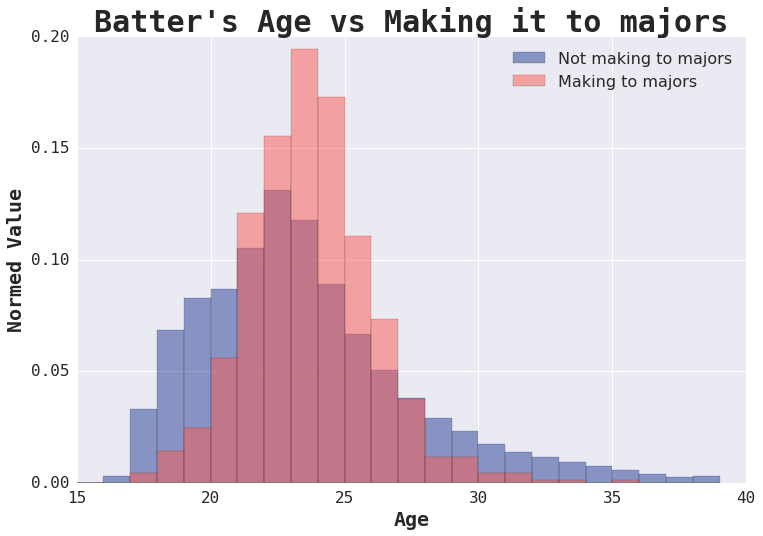

In [746]:
['#fc5a50', colors[1]]
bins = np.arange(-100, 100, 5)
#for column in X_ver2_808.columns:
fig = plt.figure(figsize=(12, 8))
histpair(X_ver2_808['Age_batting'], X_ver2_808['Rookie?'], binsize=1, xmax=40, alpha=0.5, xmin=15)
#_ = plt.hist(X_ver2_808[X_ver2_808['Rookie?'] == 1]['Age_batting'].dropna(), bins=70, stacked=True, alpha=0.7, label='Making majors', normed=True, color='#fc5a50')
#_ = plt.hist(X_ver2_808[X_ver2_808['Rookie?'] == 0]['Age_batting'].dropna(), bins=100, stacked=True, alpha=0.7, label='Not making majors', normed=True, color='#75bbfd')
plt.xlabel('Age', fontsize=20, fontweight='bold', fontname='monospace')
plt.ylabel('Normed Value', fontsize=20, fontweight='bold', fontname='monospace')
plt.xticks(fontsize=16,fontname='monospace')
plt.yticks(fontsize=16,fontname='monospace')
plt.legend(['Not making to majors', 'Making to majors'], loc='best', fontsize=16)
plt.title("Batter's Age vs Making it to majors", fontsize=30, fontweight='bold', fontname='monospace')
name = '_'.join(column.split('/'))
fig.savefig('/home/jun/Galvanize/capstone/Galvanize_capstone/Images/Hist/%s_hist.png' % name)
#plt.close(fig)

print column
#break

In [ ]:
   plt.xlabel(column, fontsize=20, fontweight='bold', fontname='monospace')
    plt.ylabel('Normed Value', fontsize=20, fontweight='bold', fontname='monospace')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(loc='best', fontsize=16)
    plt.title(column, fontsize=30, fontweight='bold', fontname='monospace')

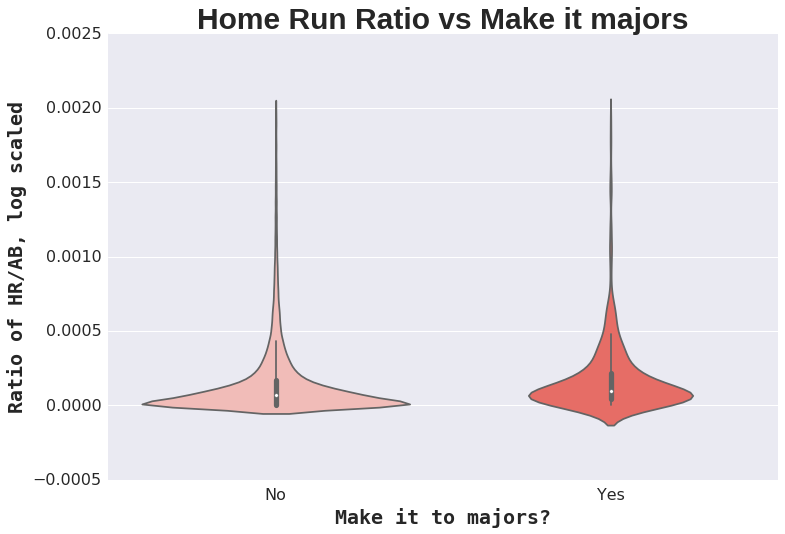

In [701]:
fig = plt.figure(figsize=(12, 8))
_ = violinplot(X_ver2_808['Rookie?'], X_ver2_808[X_ver2_808['HR_batting'] < 0.002]['HR_batting'], palette=[colors[0], '#fc5a50'])
ax = fig.add_subplot(1,1,1)
ax.set_xticklabels(['No', 'Yes'])
#ax.set_yscale('log')
plt.xlabel('Make it to majors?', fontsize=20, fontweight='bold', fontname='monospace')
plt.ylabel('Ratio of HR/AB, log scaled', fontsize=20, fontweight='bold', fontname='monospace')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Home Run Ratio vs Make it majors', fontsize=30, fontweight='bold')

TypeError: 'AxesSubplot' object is not iterable

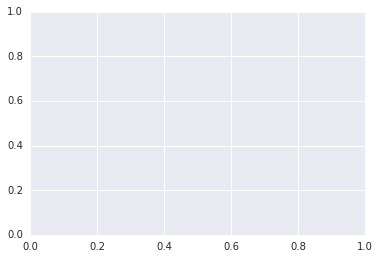

In [671]:
cm_name = 'Pastel1'
color_map = cm.get_cmap(cm_name)
colors = color_map([x/float(2) for x in [0, 1]])

bins = np.arange(-100, 100, 5)
#for column in X_ver2_808.columns:
fig, ax = plt.subplot()
#fig = plt.figure(figsize=(12, 8))
_ = plt.scatter(X_ver2_808['Rookie?'].values, X_ver2_808['HR_batting'].values, alpha=0.1, edgecolor = colors[0], facecolor='#fc5a50', s=70)
#plt.colorbar()
plt.title('HR_batting' + ' vs ' + 'Make Majors', fontsize=24, fontweight='bold', fontname='monospace')
plt.xlabel(column, fontsize=20, fontweight='bold', fontname='monospace')
plt.ylabel('Make Majors', fontsize=20, fontweight='bold', fontname='monospace')
plt.xticks([0, 1], ['No', 'Yes'], fontsize=16, fontname='monospace')
plt.yticks(fontsize=16, fontname='monospace')
name = '_'.join(column.split('/'))
fig.savefig('/home/jun/Galvanize/capstone/Galvanize_capstone/Images/%s_scatter.png' % name)

#plt.close(fig)
   
print column
   